<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/flow_spline_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spline Flow using JAX, Haiku, Optax and Distrax

In this notebook we will implement Spline flow to fit a distribution to MNIST dataset. We will be using the RationalQuadraticSpline, a piecewise rational quadratic spline, and Masked Couplings as explained in paper [Neural Spline Flows](https://arxiv.org/abs/1906.04032) by Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. 

This notebook replicates the [original distrax code ](https://github.com/deepmind/distrax/blob/master/examples/flow.py) with suitable minor modifications.
 


For implementing the Quadratic Splines with Coupling flows, We will be using following libraries:
- JAX  - NumPy on GPU, and TPU with automatic differentiation.
- Haiku - JAX based Neural Network Library.
- Optax -  gradient processing and optimization library for JAX.
- Distrax - a lightweight library of probability distributions and bijectors.

### Installing required libraries in Colab

In [ ]:
!pip install -qq -U optax distrax dm-haiku

### Importing all required libraries and packages

In [ ]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq dm-haiku
    import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

MNIST_IMAGE_SHAPE = (28, 28, 1)
batch_size = 128

### Conditioner

Let $u \in \mathbb{R}^D $ be the input. The input is split into two equal sub spaces $(x^A, x^B)$  each of size $\mathbb{R}^{d}$ such that $d = D/2$.

Let us assume we have a bijection $\hat{f}(\cdot;\theta): \mathbb{R}^d \to \mathbb{R}^d$ parameterized by $\theta $

We define a single coupling layer as a function $ f: \mathbb{R}^D \to \mathbb{R}^D $ given by $x = f(u)$ as below:

$ x^A = \hat{f}(u^A; \Theta(u^B))$

$ x^B = u^B $

$ x = (x^A, x^B)$

In other words, the input $u$ is split into $(u^A, u^B)$ and output $(x^A, x^B)$ is combined back into $x$ using a binary mask $m$. Therefore, the single coupling layer $ f: \mathbb{R}^D \to \mathbb{R}^D $ given by $x = f(u)$ is defined in a single equation as below:

$x = f(u) = b \odot u + (1-b) \hat{f}(u; \Theta(b \odot u))$

We will implement the full flow by chaining multiple coupling layers. The mask $b$ will be flipped between each layer to ensure we capture dependencies in more expressive way. 

The function **${\Theta}$** is called the **Conditioner** which we implement with a set of Linear layers and ReLU activation functions.

In [ ]:
def make_conditioner(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:
    """Creates an MLP conditioner for each layer of the flow."""
    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-len(event_shape)),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            # We initialize this linear layer to zero so that the flow is initialized
            # to the identity function.
            hk.Linear(np.prod(event_shape) * num_bijector_params, w_init=jnp.zeros, b_init=jnp.zeros),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )

### Flow Model

Next we implement the **Bijector** $\hat{f}$ using `distrax.RationalQuadraticSpline` and the **Masked Coupling** $f$ using `distrax.MaskedCoupling`

We join together sequentailly a number of masked coupling layers to define the complete Spline FLow. 

We define base distribution of our flow as **Uniform distribution**. 

In [ ]:
def make_flow_model(
    event_shape: Sequence[int], num_layers: int, hidden_sizes: Sequence[int], num_bins: int
) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = jnp.arange(0, np.prod(event_shape)) % 2
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=0.0, range_max=1.0)

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(event_shape, hidden_sizes, num_bijector_params),
        )
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.Uniform(low=jnp.zeros(event_shape), high=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape),
    )

    return distrax.Transformed(base_distribution, flow)

### Data Loading and preparation
In this cell, we define a function to load the MNIST dataset using TFDS (Tensorflow Datasets) package.

We also have a function `prepare_data` to: 
1. dequantize the data i.e. to convert the integer pixel values from `{0,1,...,255}` to real number values `[0,256)` by adding a random uniform noise `[0,1)`; and 

2. Normalize the pixel values from `[0,256)` to `[0,1)`  

The dequantization of data is done only at training time.

In [ ]:
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    data = batch["image"].astype(np.float32)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)
    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

### Log Probability, Sample and training loss Functions
Next we define the `log_prob` `model_sample` and `loss_fn`. `log_prob` is responsible for calculating the log of the probability of the data which we want to maximize for MNIST data inside `loss_fn`.

`model_sample` allows us to sample new data points after the model has been trained on MNIST. FOr a well trained model, these samples will look like MNIST digits generated synthetically.

In [ ]:
flow_num_layers = 8
mlp_num_layers = 2
hidden_size = 500
num_bins = 4
learning_rate = 1e-4

# using 100,000 steps could take long (about 2 hours) but will give better results.
# You can try with 10,000 steps to run it fast but result may not be very good

training_steps = 10000
eval_frequency = 1000

In [ ]:
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array) -> Array:
    model = make_flow_model(
        event_shape=MNIST_IMAGE_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    return model.log_prob(data)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int) -> Array:
    model = make_flow_model(
        event_shape=MNIST_IMAGE_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    return model.sample(seed=key, sample_shape=[num_samples])


def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
    data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss

### Training   
Next we define, the `update` function for the gradient update. We use `jax.grad` to calculate the gradient of loss wrt model parameters.  

In [ ]:
optimizer = optax.adam(learning_rate)


@jax.jit
def update(params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

Now we carry out the training of the model.

In [ ]:
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(next(prng_seq), np.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = optimizer.init(params)
train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)
for step in range(training_steps):
    params, opt_state = update(params, next(prng_seq), opt_state, next(train_ds))

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")

STEP:     0; Validation loss: -5.243
STEP:  1000; Validation loss: -3330.548
STEP:  2000; Validation loss: -3316.721
STEP:  3000; Validation loss: -3319.474
STEP:  4000; Validation loss: -3321.137
STEP:  5000; Validation loss: -3297.604
STEP:  6000; Validation loss: -3295.713
STEP:  7000; Validation loss: -3260.267
STEP:  8000; Validation loss: -3263.344
STEP:  9000; Validation loss: -3286.821
STEP: 10000; Validation loss: -3301.308
STEP: 11000; Validation loss: -3296.085
STEP: 12000; Validation loss: -3310.035
STEP: 13000; Validation loss: -3326.781
STEP: 14000; Validation loss: -3305.100
STEP: 15000; Validation loss: -3317.956
STEP: 16000; Validation loss: -3365.609
STEP: 17000; Validation loss: -3339.233
STEP: 18000; Validation loss: -3346.478
STEP: 19000; Validation loss: -3325.882
STEP: 20000; Validation loss: -3340.056
STEP: 21000; Validation loss: -3342.137
STEP: 22000; Validation loss: -3338.241
STEP: 23000; Validation loss: -3354.057
STEP: 24000; Validation loss: -3384.099
STE

### Sampling from Trained Flow Model

### Plot new samples
After the model has been trained in MNIST, we draw new samples and plot them. Once the model has been trained enough, these should look like MNIST dataset digits.

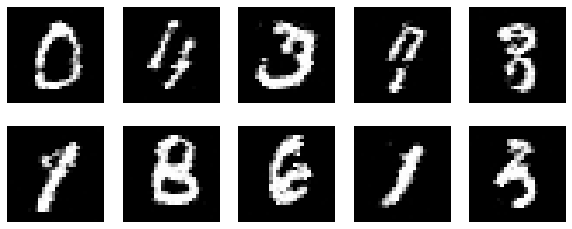

In [ ]:
def plot_batch(batch: Batch) -> None:
    """Plots a batch of MNIST digits."""
    images = batch.reshape((-1,) + MNIST_IMAGE_SHAPE)
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(images[i]), cmap="gray")
        plt.axis("off")
    plt.show()


sample = model_sample.apply(params, next(prng_seq), num_samples=10)
plot_batch(sample)